# Tensorflow Experiments on Neural Ordinary Differential Equations (v1.1)

> You can contact me on twitter as [@mandubian](http://twitter.com/mandubian)

This notebook is a sandbox to test concepts exposed in this amazing paper:

> Neural Ordinary Differential Equations
> http://arxiv.org/abs/1806.07366
>
> Authors: 
>    Chen, Ricky T. Q.
>    Rubanova, Yulia
>    Bettencourt, Jesse
>    Duvenaud, David

My idea is to reproduce the concepts exposed in the paper fully in Tensorflow using Eager-Mode and GradientTape. 

I didn't want to depend on Autograd and to be able to use classic Keras models.

For ODE Solver, I wanted to compare implementations in TF with Scipy very robust ones (the only one I found is Runge-Kutta Dopri5).

v1.1:
- Added batched TF augmented gradient
- Added mini-batch optimization inspired by cool Pytorch implementation https://github.com/rtqichen/torchdiffeq allowing to have much faster converging & deterministic training

v1.0:
- First Implementation of TF augmented gradient
- Samples with basic optimization on whole dataset

## A few preliminary ideas (to let you scratch your head with me)

> Skip it if you just want to see it running

### Modeling the derivative of hidden state

Deep neural networks as we know in general are aimed at simulating a function $y = f(x)$ from a set of known inputs/outputs (a supervised learning based on a groundtruth). The classic approach is to represent the function with inputs, outputs and a _hidden state_ we don't know but want to learn. This hidden state is represented by a sequence of discrete deep neural layers whose internal parameters are learnt by step by step back-propagation of gradients on a chosen derivable loss function and an optimization mechanism to reach the best minimum (ideally global). So the hidden state to be learnt is parameterized by the trainable parameters of those discrete layers.

>In _Neural ODE_ paper (http://arxiv.org/abs/1806.07366), the authors propose a new approach by modeling not the hidden state of the function but the derivative of the hidden state.


### Residual layer as Ordinary Differential Equation

The authors make this assumption starting from the case of well-known residual neural networks _ResNet_ constituted of multiple residual layers. A residual layer is meant to _keep in memory_ what you knew in previous layer and to slighly update it without forgetting it. A residual layer can be represented by the following equation:

$$
z_{t+1} = z_t + f(z_t, {\theta}_t) \\
$$

where:
- $z_t$ is the input of the layer
- $z_{t+1}$ is the output of the layer
- $f$ is the function parameterized by $θ_t$ that we want to learn
- $t$ can be seen as the depth of this layer in a full ResNet with $0, 1, ..., t, t+1, ..., t+n$ successive residual layers.

Previous equation can be rewritten as:

$$
z_{t+1} - z_t = f(z_t, {\theta}_t) * ({\delta}_t = 1) \\
or \\
\frac {z_{t+1} - z_t} {({\delta}_t = 1)} = f(z_t, {\theta}_t)
$$

${\delta}_t = 1$ can be seen as discrete depth increment going from one residual layer to the next in the ResNet.


Let's now consider this depth $t$ is no more discrete but continuous. We can easily infer the following:

$$
\begin{aligned}
{\frac {dz(t)}{dt}} = f(z(t), t, {\theta})
\end{aligned}
$$

The previous equation is called an _ordinary differential equation (ODE)_. There is a whole field of study in mathematics about solving ordinary differential equations, with so-called _ODE Solvers_, i.e solving equations of kind:

$$
\text{Find } z(t) \text{ knowing }
\begin{aligned}
{\frac {dz(t)}{dt}} & = f(z(t), t) \\
\end{aligned}
\text{ given an initial value }
\begin{aligned}
z(t_{0}) & = z_{0} \\
\end{aligned} \text{ and a discretized interval }
\begin{aligned}
{t_0, t_1, ... t_n}
\end{aligned}
$$

ODE Solvers are numerical methods to compute fast but robust approximated integrals (analytical methods exist but can't solve many cases of ODE like $\dot{y} = sin(x^2 + y^2)$). During your math study, you might have seen this Euler method https://en.wikipedia.org/wiki/Euler_method of approximating a function by using a naive construction with the tangent, an incremental step and an initial point on the curve. I'm not a mathematician so I won't teach you anything about ODE Solvers, you just need to know that this field has been studied and used intensively in multiple real-life apps (physics, geology, meteo, finance, chemistry etc...) and provide very efficient, optimized algorithms implemented in multiple libs and for example Scipy provides nice implementations of different ODE solvers.



### Computing hidden state using ODE Solver

Let's imagine we have a ResNet with multiple residual layers of depths $0, 1, ..., t, t+1, ..., t+n$. In a classic ResNet, all layers have their own function $f_t$ but if we mutualize this function for all layers, we can generalize to the whole network:

$$
\begin{aligned}
{\frac {dz(t)}{dt}} & = f(z(t), t)\hspace{0.5cm}\forall{t} \in [t_0, t_1, ...t_n]
\end{aligned}
$$

So the $f$ function of this ResNet can be seen as the derivative of the hidden state ${\frac {dz(t)}{dt}}$ we are trying to learn.

Using ODE Solver, if we know $f$ and an initial value $z(t_{0})$ and this interval discretization ${t_0, t_1, ..., t_n}$, we can compute a robust approximation $z(t)$ in the following way:

$$
\begin{aligned}
z(t_n) & = ODESolve(z(t_0), f, [t_0, t_1, ...t_n], θ) 
\end{aligned}
$$

where:
- $t_0$ is the initial layer
- $[t_0, t_1, ...t_n]$ is the discretized interval
- $z(t_0)$ is the initial value of the function
- $z(t_n)$ is the output value of our network
- $t_n$ is the output layer
- ${\theta}$ are the parameters of the function $f$ we want to learn




### Depth as an input parameter of neural model

$[t_0, t_1, ...t_n]$ represents the depth distribution of the layers of our _mono-function_ ResNet. In a classic network, the depth in terms of layers is a static part of the architecture of the network which can't be changed without retraining completely the network.

In our case, depth distribution becomes a continuous space that we discretized and provide as a dynamic parameter to the ODE Solver at training or inference. We can imagine having different depth distribution at training or inference to speed computations for example. We could even imagine using more complicated depth distribution like non linear distribution or even learning an optimized shape for a given problem. Next studies...

There is also an immediate analogy between this depth distribution and time distribution. It also quickly reminds of time-series issues and recurrent neural networks... They speak about it in the paper but I still haven't implemented that part... Next steps...


### Back-propagation by backward ODE Solving

So that's cool but how do you represent and learn those ${\theta}$???

I won't go in deep demonstration as it would be too long. Don't worry if you don't catch this part :D

It starts with a classic neural network representing our derivative $f$ with internal parameters $\theta$.

Let simplify to a 1-step time interval $[t_0, t_1]$, an initial input value $z(t_0)$ and our known output $groundtruth(t_1)$.

First, it computes current estimated value $z({t_1})$ by a classic forward computation with a call to our ODE Solver using current $\theta$ and input value $z(t_0)$.

$$
\begin{aligned}
z(t_1) = ODESolve(z(t_0), f, [t_0, t_1], {\theta})
\end{aligned}
$$

Then, it computes the classic Loss function:

$$
\begin{aligned}
L(z(t_1), groundtruth(t_1)) & = L(ODESolve(z(t_0), f, [t_0, t_1], {\theta}), groundtruth(t_1))
\end{aligned}
$$

The authors then consider the so-called _adjoint state_ (adjoint state method is the math _trick_ at the origin of backward auto-differentiation _aka_ gradient back-propagation that often simplifies gradient computation as neural networks are often many-to-scalars functions with lower gradient complexity in backward mode... This is another topic)

$$
\begin{aligned}
a(t) = − {\frac {\partial L(z(t))}{\partial z(t)}}
\end{aligned}
$$


The paper appendix proves that:

$$
\begin{aligned}
{\frac {da(t)}{dt}} = - a(t){\frac {\partial{f(z(t), t, \theta)}}{\partial z}}
\end{aligned}
$$

and the same respectively for ${\frac {da(t)}{d\theta}}$ and ${\frac {da(t)}{dt}}$

${\frac {\partial{f(z(t), t, \theta)}}{\partial z}}$ is the classic gradient we already compute in normal residual layer using back-propagation.

Knowing all the derivatives of $a(t)$ with respect to $z(t), t, \theta$, we can then compute $a(t)$ with a call to ODE Solver going backward in time from $t_1$ to $t_0$. The initial value is the gradient of loss ${\frac {\partial L(z(t_1))}{\partial z}}$ at $t_1$ between our current output $z(t_1)$ and our groundtruth...

$$
\begin{aligned}
s0 & = [z(t1), {\frac {\partial L}{\partial z(t_1)}}, 0, −{\frac {\partial L}{t_1}}] \\
[z(t_0), {\frac {\partial L}{\partial z(t_0)}}, {\frac {\partial L}{\partial θ}}, {\frac {\partial L}{\partial t}}] & = ODESolve(z(t_0), augmented_f, [t_1, t_0], {\theta})
\end{aligned}
$$

By using a bit more machinery (an _augmented state_ grouping $z(t)$, ${\frac {da(t)}{dz}}$, ${\frac {da(t)}{d\theta}}$, ${\frac {da(t)}{dt}}$ together), the paper demonstrates how all required backward gradients can be computed in one single call to ODESolver and then you can train your parameters using a classic optimizer like SGD or Adam...

Not so clear? It's normal :D


### Conclusion

By representing the residual-like hidden-state through its derivative and a _continuous_ depth distribution, it's possible to train model parameters with ODE Solvers. The hidden-state of the derivative is still represented by a static human-engineered discrete sequence of neural layers but the depth distribution becomes an input parameter of the network that can be changed dynamically at training or inference.

Is it going to change your life as a datascientist drastically? Not yet... But it's bringing new cool ideas on how we can represent neural networks in another way, how it learns, how residual layers work. It opens new fields of study, drawing bridges between Deep Learning and existing older branches of mathematics. It also bring diversity in DL domain that IMHO tends to re-use the same tricks without always catching how they work.

#### Other sources of inspiration

There are more precise details in this nice article https://rkevingibson.github.io/blog/neural-networks-as-ordinary-differential-equations/ and then read the paper first pages, it's quite simple after all. If I can understand it, you can too...

This notebook is also very inspired by this cool article on Neural ODE & appealing Julia:

https://julialang.org/blog/2019/01/fluxdiffeq


If you want to know more about ODE Solvers, there is a whole litterature about it with lots of different methods like `Runge-Kutta` or `LSODA` used in this notebook and you can find more details in scipy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint



#### Code under MIT License

```
Copyright 2019 Pascal Voitot

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```


## Initialization

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import time
import os
import numpy as np
import scipy.integrate
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

import tensorflow as tf
print("tensorflow version: ", tf.__version__)


tensorflow version:  1.12.0


In [2]:
tf.enable_eager_execution()
init_notebook_mode(connected=True)

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Test ODE Solvers (TF and Scipy)

Let a derivative function:

$
\hspace{1cm}f'(t) = 2t
$

Let a set of values $t \in [0, 4.0]$

Let the initial value be $f(t_0) = 0.0$

A good ODE Solver should integrate to a parabolic:

$
\hspace{1cm}f(t) = t^2
$


## Test Full-TF ODE Solver (Runge-Kutta - Adaptative - Explicit - Dopri5)

> `Dopri5` is an explicit runge-kutta method of order (4)5 due to Dormand & Prince (with stepsize control and dense output).
>
> Authors:
> E. Hairer and G. Wanner Universite de Geneve, Dept. de Mathematiques CH-1211 Geneve 24
>
> **Please note that this implementation works well but the method tends to be less stable computationally speaking than the scipy LSODA implicit method used below**

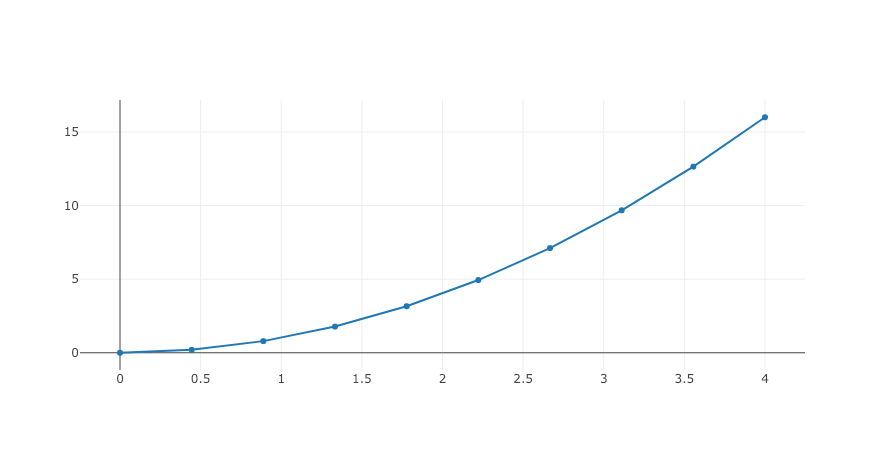

In [8]:
ts = np.linspace(0., 4.0, 10)

ys, info = tf.contrib.integrate.odeint(lambda y, t: tf.to_float(2*t), 0.0, ts, rtol = 0.01, full_output=True)

iplot([go.Scatter(x=ts, y=ys.numpy())])

## Test Scipy ODE Solver (LSODE)

> By default Scipy is using on LSODA Solver method (there are other methods, even DOPRI5)
>
> Real-valued Variable-coefficient Ordinary Differential Equation solver, with fixed-leading-coefficient implementation. It provides automatic method switching between implicit Adams method (for non-stiff problems) and a method based on backward differentiation formulas (BDF) (for stiff problems).
>
> Source: http://www.netlib.org/odepack
>
> **Please note that this implementation is more stable computionally speaking than full-TF implementation above**



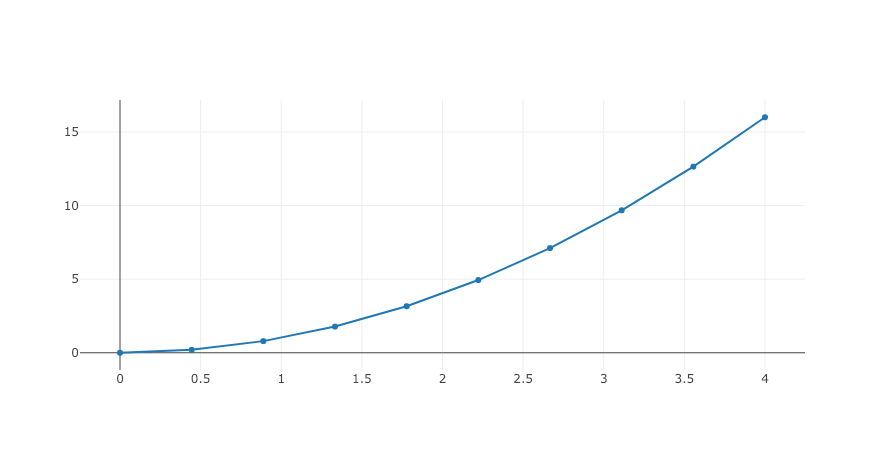

In [5]:
ts = np.linspace(0., 4.0, 10)

ys = scipy.integrate.odeint(lambda y, t: 2*t, [0.0], ts)

iplot([go.Scatter(x=ts, y=np.squeeze(ys))])

## Illustrating ODE Solvers with oscillators

### Two-dimensional damped oscillator

http://www.dam.brown.edu/people/mraissi/research/7_multistep_neural_networks/

Let us consider the two-dimensional damped harmonic oscillator with cubic dynamics:

$
\begin{align}
{\frac {dx} {dt}} & = −0.1x^3 + 2.0y^3 \\
{\frac {dy} {dt}} & = −2.0x^3 − 0.1y^3 \\
z & = (x, y)
\end{align}
$

In [4]:
# z = [x, y]
def damped_oscillator_2d(z, t, A):
    return np.dot(z**3, A)

A = np.array([
    # −0.1x^3 + 2.0y^3
    [-0.1, 2.0],
    # −2.0x^3 − 0.1y^3
    [-2.0, -0.1]])

# Initial u0 = [x0, y0]
z0 = np.array([2., 0.]).T

# Time sampling
N = 1000  # Dataset size
max_T = 25.0 # Time sampling
ts = np.linspace(0., max_T, N)


#### TF-RungeKutta ODE Solver

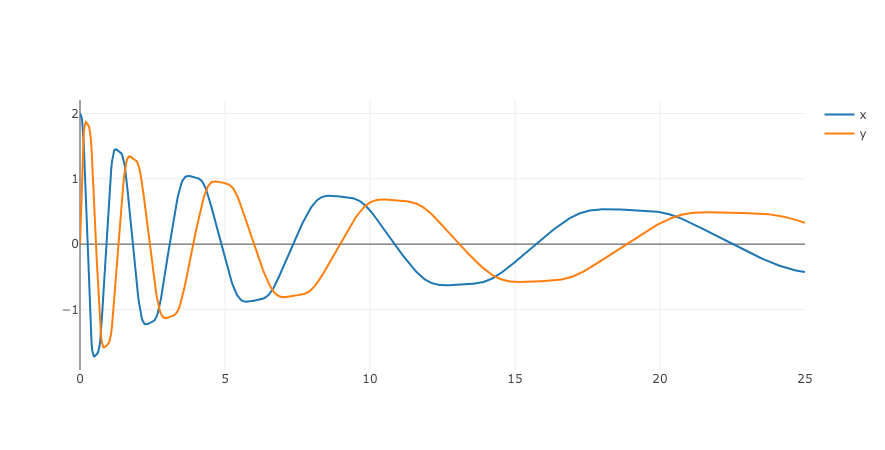

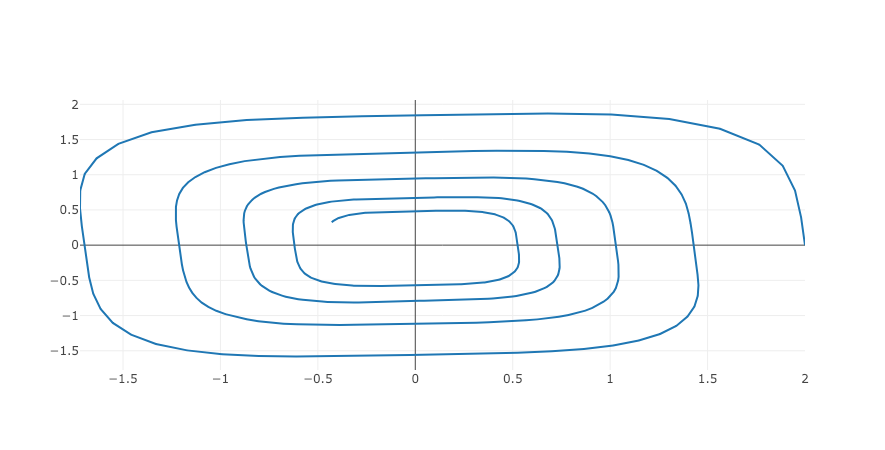

In [7]:
zs, info = tf.contrib.integrate.odeint(lambda z0, ts: tf.tensordot(z0**3, A, axes=1), z0, ts,
                                method="dopri5", options={"max_num_steps":10, "first_step": 0.1}, rtol = 0.001,
                                full_output=True)
zs = zs.numpy()
xs = zs[:, 0]
ys = zs[:, 1]
iplot([go.Scatter(x=ts, y=xs, name="x"), go.Scatter(x=ts, y=ys, name="y")])
iplot([go.Scatter(x=xs, y=ys)])

#### Scipy ODE Solver

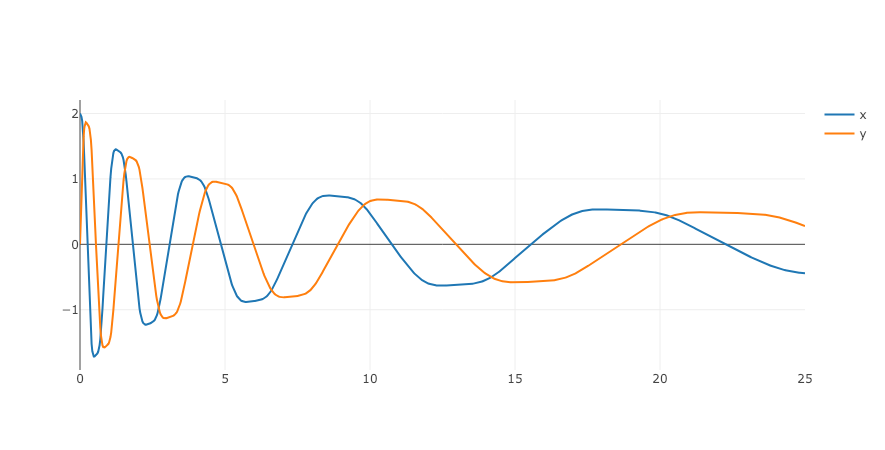

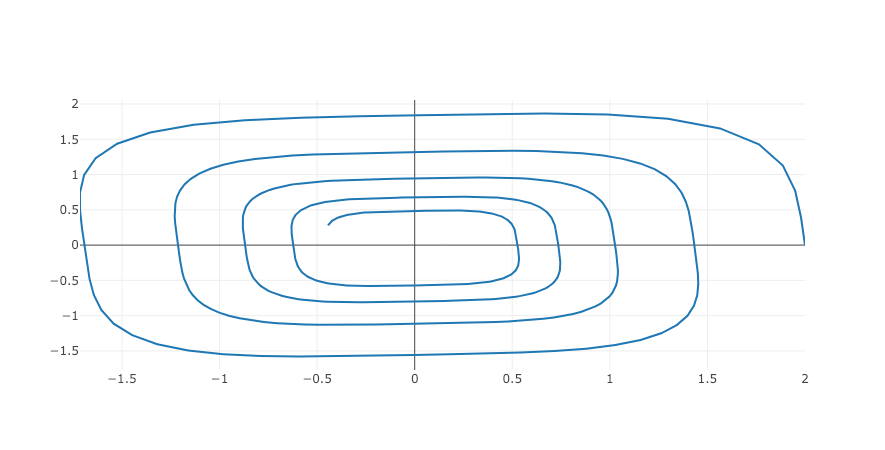

In [8]:
zs = scipy.integrate.odeint(damped_oscillator_2d, z0, ts, args=(A,))

xs = zs[:, 0]
ys = zs[:, 1]
iplot([go.Scatter(x=ts, y=xs, name="x"), go.Scatter(x=ts, y=ys, name="y")])
iplot([go.Scatter(x=xs, y=ys)])

## Helpers to call ODE Solvers from TF

In [5]:
def ode_tf(f, z0, ts, args):
    """calls Full TF ODE Runge-Kutta Dopri5 Solver
    
    Args:
        f: a function of type (z0, ts, args) -> ys
            where z0, the initial value
                  ts, the time values
                  args, the supplementary args

        z0: initial value
        ts: time values on which to solve equation
        args: supplementary arsg
        
    Returns:
        array of solutions computed by ODE Solver
    Please note, TF solver params are hard-coded here but they could be managed in a cleaner way
    """
    # current TF odeint implementation doesn't manage args so we need this lambda
    zs, info = tf.contrib.integrate.odeint(
        lambda z0, ts: f(z0, ts, args), z0, ts,
        method="dopri5",
        options={"max_num_steps":1000, "first_step": 0.001},
        rtol = 0.001,
        full_output=True
    )
    return zs

def ode_tf_batch(f, z0s, ts, args):
    """Calls Full TF ODE Runge-Kutta Dopri5 Solver simulating Batch Mode by splitting on batch dim
    to compare to using ode_tf in batch mode (batch management is not what you expect)
    """
    rs = []
    for z0 in tf.split(z0s, z0s.shape[0], axis=0):
        z0 = tf.squeeze(z0)
        r = ode_tf(f, z0, ts, args)
        r = tf.expand_dims(r, axis=0)
        rs.append(r)
    rs = tf.keras.backend.concatenate(rs, axis=0)
    return rs

def ode_scipy(f, z0, ts, args):
    """Calls Python Scipy ODE Solver from TF
    
    Args:
        f: a function of type (z0, ts, args) -> ys
            where z0, the initial value
                  ts, the time values
                  args, the supplementary args

        y-z0: initial value
        ts: time values on which to solve equation
        args: supplementary args

    Returns:
        array of solutions computed by ODE Solver
    """
    # managing args as None... this is ugly but simplifies a bit later code
    if args is not None:
        r = tf.py_func(
            lambda z0, ts, args: scipy.integrate.odeint(f, z0, ts, args=(args,)),
            [z0, ts, args], z0.dtype)
    else:
        r = tf.py_func(
            lambda z0, ts: scipy.integrate.odeint(f, z0, ts, args=(None,)),
            [z0, ts], z0.dtype)
    return r


def ode_scipy_batch(f, z0s, ts, args):
    """Calls Python Scipy Solver simulating Batch Mode by splitting along batch dim"""
    rs = []
    for z0 in tf.split(z0s, z0s.shape[0], axis=0):
        z0 = tf.squeeze(z0)
        r = ode_scipy(f, z0, ts, args)
        r = tf.expand_dims(r, axis=0)
        rs.append(r)
    rs = tf.keras.backend.concatenate(rs, axis=0)
    return rs

## Lotka–Volterra equations (the funny predators/preys or rabbits/foxes equations)

> This sample was taken from article https://julialang.org/blog/2019/01/fluxdiffeq

https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations

$
\begin{aligned}
{\frac {dx}{dt}} & = \alpha x - \beta xy, \\
{\frac {dy}{dt}} & = \delta xy - \gamma y
\end{aligned}
$

where

$x$ is the number of preys (for example, rabbits);
$y$ is the number of predators (for example, foxes);

${\frac {dy}{dt}}$ and ${\frac {dx}{dt}}$ represent the instantaneous growth rates of the two populations;

$t$ represents time

$α, β, γ, δ$ are positive real parameters describing the interaction of the two species.



In [6]:
# Numpy or eager-mode TF
def lotka_volterra(z, ts, args):
    # batch mode on z
    if len(z.shape) > 1:
        x, y = z[:, 0], z[:, 1]
        α, β, δ, γ = args[0], args[1], args[2], args[3]
        dx = α*x - β*x*y
        dy = -δ*y + γ*x*y
        return tf.stack([dx, dy], axis=1)
    else:
        x, y = z[0], z[1]
        α, β, δ, γ = args[0], args[1], args[2], args[3]
        dx = α*x - β*x*y
        dy = -δ*y + γ*x*y
        return tf.stack([dx, dy], axis=0)

# Tensorflow Variables
D = 2
# time interval from 0 to 10 divided in 100 steps
N = 1000
ts = tf.constant(np.linspace(0., 10.0, N))
# initial arguments
args = tf.Variable(tf.constant([1.5, 1.0, 3.0, 1.0], shape=(4,), dtype=ts.dtype))
z0 = tf.Variable(tf.constant([1.0,1.0], shape=(2,), dtype=ts.dtype))


#### TF-RungeKutta ODE Solver

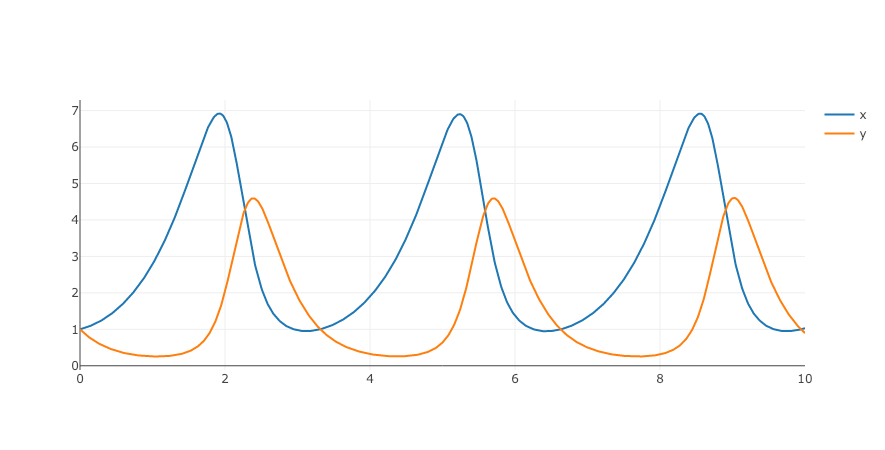

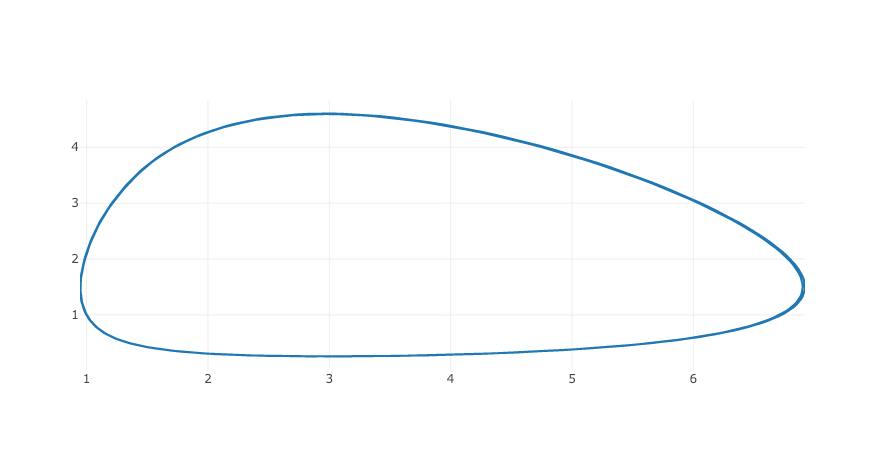

In [7]:
sol = ode_tf(lotka_volterra, z0, ts, args)
xs = sol[:, 0].numpy()
ys = sol[:, 1].numpy()

iplot([go.Scatter(x=ts.numpy(), y=xs, name="x"), go.Scatter(x=ts.numpy(), y=ys, name="y")])

iplot([go.Scatter(x=xs, y=ys)])

#### Scipy ODE Solver

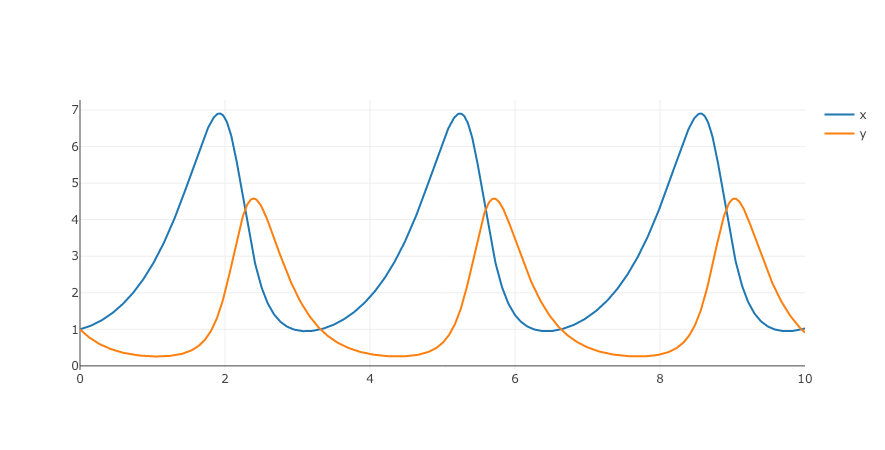

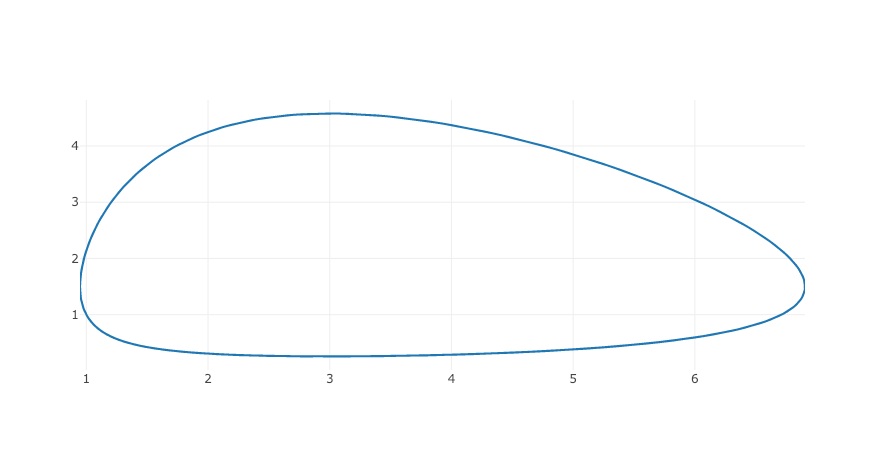

In [10]:
sol = ode_scipy(lotka_volterra, z0, ts, args)
xs = sol[:, 0].numpy()
ys = sol[:, 1].numpy()

iplot([go.Scatter(x=ts.numpy(), y=xs, name="x"), go.Scatter(x=ts.numpy(), y=ys, name="y")])

iplot([go.Scatter(x=xs, y=ys)])

### Testing ODE Scipy on Batch of initial values

In [107]:
z1 = tf.expand_dims(z0, -1)
z0s = tf.tile(tf.expand_dims(z0, -1), [1, 2])
sol = ode_scipy_batch(lotka_volterra, z0s, ts, args)
print(sol.shape)

RS: (2, 100, 2)
(2, 100, 2)


## Augmented State in Tensorfow Eager-mode + GradientTape

This is an implementation of the augmented-state gradient computed by ODE-Solver code sample found in Neural ODE paper made in pure TF 1.x in eager-mode and using Gradient-Tape.

To be clear, that was a true pain to implement it and it's still not stable IMHO...

I don't pretend this is nice or idiomatic code but it works now and enables experimentations...

In [7]:
def flatten(params):
    """flatten a list of tensors/arrays into a flat tensor and returns also the unflatten function
    able to rebuild original list from flattenned tensor
    """
    if len(params) == 0:
        def unflatten(flat_params):
            return flat_params
        return np.array(params), unflatten
    
    original_shapes = []
    flat_params = []
    default_dtype = params[0].dtype
    for p in params:
        sh = p.shape
        original_shapes.append(sh)
        flat_sh = 1
        for s in sh:
            flat_sh *= s

        res = tf.reshape(p, (flat_sh,))
        res = tf.cast(res, default_dtype)
        flat_params.append(res)
    
    def unflatten(flat_params):
        cur_idx = 0
        params = []
        for sh in original_shapes:
            flat_sh = 1
            for s in sh:
                flat_sh *= s
            param = flat_params[cur_idx:cur_idx + flat_sh]
            param = tf.reshape(param, sh)
            cur_idx += int(flat_sh)
            params.append(param)
            
        return params
            
    flat_params = tf.concat(flat_params, axis=0)
    return flat_params, unflatten

# Directly inspired from function implemented with autograd at the end of the paper
# Extended from "Scalable Inference of Ordinary Differential
# Equation Models of Biochemical Processes", Sec. 2.4.2
# Fabian Froehlich, Carolin Loos, Jan Hasenauer, 2017
# https://arxiv.org/abs/1711.08079
def grad_odeint(z_ts, func, ts, args, T, D, ode_solver, variables = None):
    """
    This code is still ugly and not very robust IMHO...
    It's full of reshape that might be unneeded but at least I know what I manipulate without compilted types
    
    Args:
        z_ts: the values with ODE Solver in forward path on ts time values
        func: the adjoint gradient function to integrate with ODE Solver
        ts: the discretized time values
        args: the derivable arguments of func
        ode_solver: the ode_solver function (z0, ts, args) -> zs
        variables: the hidden TF/Keras tensor variables (separated from args to be manageable as they have their own life cycle I'm not sure to understand yet)

    Returns:
        grad: the custom augmentate-state TF gradient function
    """
    # let's store
    if variables is not None:
        flat_variables, unflatten_variables = flatten(variables)

    def unpack_D_2D(x, D):
        """simple extract """
        x = tf.squeeze(x)
        return (
            x[0:D],
            x[D:2 * D]
        )
        
    # augmented_state = [z_t, a_z_t, a_t, a_args, a_vars]
    def a_gradient_aug(augmented_state, t, args):
        augmented_state = tf.convert_to_tensor(augmented_state, dtype=z_ts.dtype)
        t = tf.convert_to_tensor(t, dtype=ts.dtype)
        t = tf.reshape(t, (1,))
        args = tf.convert_to_tensor(args, dtype=args.dtype)
        z_t, a_z_t = unpack_D_2D(augmented_state, z_ts.shape[1])

        # the internal gradient-tape computing second derivative
        with tf.GradientTape() as gg:
            gg.watch(args)                
            gg.watch(a_z_t)
            gg.watch(t)
            gg.watch(z_t)
            dz_dt = func(z_t, t, args)

        if variables is not None:
            da_z_dt, da_t_dt, da_args_dargs, da_dvars = gg.gradient(
                dz_dt, [z_t, t, args, variables], output_gradients = -a_z_t)
        else:
            da_z_dt, da_t_dt, da_args_dargs = gg.gradient(
                dz_dt, [z_t, t, args], output_gradients = -a_z_t)
            da_dvars = None
        
        if da_z_dt is None:
            da_z_dt = tf.zeros_like(z_t, dtype=z_t.dtype)
        if da_t_dt is None:
            da_t_dt = tf.zeros_like(t, dtype=t.dtype)
        if da_args_dargs is None:
            da_args_dargs = tf.zeros_like(args, dtype=args.dtype)
        if da_dvars is None:
            da_dvars = tf.zeros_like((1,))
        else:
            da_dvars, _ = flatten(da_dvars)
        r, _ = flatten([dz_dt, da_z_dt, da_t_dt, da_args_dargs, da_dvars])
        return r

    def grad(gt):
        """the TF custom gradient function"""
        
        # initialization of backward gradient computation starting at the end of time interval
        dl_dz_t = gt[-1, :]
        dl_dt0 = tf.constant([0.], shape=(1,), dtype=ts.dtype)
        dl_dargs = tf.zeros_like(args, dtype=ts.dtype)
        if variables is not None:
            dl_dvars = tf.zeros_like(flat_variables, dtype=flat_variables.dtype)
        else:
            dl_dvars = tf.zeros((1,))
        dl_dt_list = []

        # compute gradient back-propagation by ODE solver calls going backward in time
        for i in range(T - 1, 0, -1):
            # Compute effect of moving back in time (just porting formulas found in paper)
            ztsi = z_ts[i, :]
            gti = gt[i, :]
            # Compute the adjoint gradient of loss at current time
            fi = func(ztsi, ts[i], args)
            dl_dt = tf.tensordot(fi, tf.transpose(gti), axes=1) #, axes=[[1], [0]])
            #dl_dt = tf.reshape(dl_dt, (1,))
            dl_dt_list.append(dl_dt)
            dl_dt0 = dl_dt0 - dl_dt
            #dl_dt0 = tf.reshape(dl_dt0, shape=(1,))
            # build augmented state
            aug_z0, unflatten_aug = flatten([ztsi, dl_dz_t, dl_dt0, dl_dargs, dl_dvars])
            # Run augmented system backwards to the previous observation using ODE_Solver
            cur_ts = tf.reverse(tf.slice(ts, [i-1], [2]), axis=[0])
            a_aug = ode_solver(lambda aug, t, args: a_gradient_aug(aug, t, args), aug_z0, cur_ts, args)

            # get at ts[i - 1]
            a_aug = a_aug[1]
            _, dl_dz_t, dl_dt0, dl_dargs, dl_dvars = unflatten_aug(a_aug)

            # Add gradient from current output.
            dl_dz_t = dl_dz_t + gt[i - 1, :]

        #dl_dt0 = tf.reshape(dl_dt0, (1,))
        dl_dt_list.append(dl_dt0)
        dl_dts = tf.stack(dl_dt_list, axis=0)
        dl_dts = tf.reverse(dl_dts, axis=[0])

        # output z_t is not needed but can't put None in TF tensors
        n_o_n_e = tf.zeros_like(z_ts) #, dtype=z_ts.dtype)
        
        if variables is not None:
            return [n_o_n_e, dl_dz_t, dl_dts, dl_dargs], unflatten_variables(dl_dvars)
        else:
            return [n_o_n_e, dl_dz_t, dl_dts, dl_dargs], []
    return grad

def tf_ode_grad(f, N, D, ode_solver):
    """The plug in custom_gradient TF mechanism"""
    @tf.custom_gradient
    def custom_grad(z0, ts, args):
        z0 = tf.squeeze(z0)
        # forward values computation with ODE Solver
        ys = ode_solver(f, z0, ts, args)
        def grad_fn(dr, variables=None):
            # backward gradient computation using backward ODE Solver
            (_, dl_dz_t, dl_dts, dl_dargs), dl_dvars = grad_odeint(ys, f, ts, args, N, D, ode_solver, variables)(dr)
            return [dl_dz_t, dl_dts, dl_dargs], dl_dvars
        return ys, grad_fn
    return custom_grad



### Batch-aware Augmented Gradient

In [8]:

def flatten_batch(params):
    """Batch-aware flatten a list of tensors/arrays into a flat tensor and returns also the unflatten function
    able to rebuild original list from flattenned tensor
    """
    if len(params) == 0:
        def unflatten(flat_params):
            return flat_params
        return np.array(params), unflatten
    
    original_shapes = []
    flat_params = []
    default_dtype = params[0].dtype
    batch_size = params[0].shape[0]
    for p in params:
        sh = p.shape
        original_shapes.append(sh)
        flat_sh = 1
        for s in sh[1:]:
            flat_sh *= s

        res = tf.reshape(p, (batch_size, flat_sh,))
        res = tf.cast(res, default_dtype)
        flat_params.append(res)
    
    def unflatten(flat_params):
        cur_idx = 0
        params = []
        for sh in original_shapes:
            flat_sh = 1
            for s in sh[1:]:
                flat_sh *= s
            param = flat_params[:, cur_idx:cur_idx+flat_sh]
            param = tf.reshape(param, sh)
            cur_idx += int(flat_sh)
            params.append(param)
            
        return params
            
    flat_params = tf.concat(flat_params, axis=1)
    return flat_params, unflatten
    
    

# Directly inspired from function implemented with autograd at the end of the paper
# Extended from "Scalable Inference of Ordinary Differential
# Equation Models of Biochemical Processes", Sec. 2.4.2
# Fabian Froehlich, Carolin Loos, Jan Hasenauer, 2017
# https://arxiv.org/abs/1711.08079
def grad_odeint_batch(z_ts, func, ts, args, T, D, ode_solver, variables = None):
    """
    Batch-aware augmented gradient
    
    Args:
        z_ts: (batch_size, batch_time, D) the values with ODE Solver in forward path on ts time values
        func: the adjoint gradient function to integrate with ODE Solver
        ts: (batch_time,) the discretized time values
        args: the derivable arguments of func
        ode_solver: the ode_solver function (z0, ts, args) -> zs
        variables: the hidden TF/Keras tensor variables (separated from args to be manageable as they have their own life cycle I'm not sure to understand yet)

    Returns:
        grad: the custom augmentate-state TF gradient function
    """
    # let's store
    if variables is not None:
        flat_variables, unflatten_variables = flatten(variables)
        vars_batch = []
        for var in variables:            
            var = tf.expand_dims(var, 0)
            if len(var.shape) > 2:
                var = tf.tile(var, [z_ts.shape[0], 1, 1])
            else:
                var = tf.tile(var, [z_ts.shape[0], 1])
            
            vars_batch.append(var)
        flat_variables_batch, unflatten_variables_batch = flatten_batch(vars_batch)
        

    def unpack_D_2D(x, D):
        """simple extract """
        #x = tf.squeeze(x)
        if len(x.shape) > 1:
            return (
                x[:, 0:D],
                x[:, D:2 * D]
            )
        else:
            return (
                x[0:D],
                x[D:2 * D]
            )
        
    # batch-aware gradient function able to manage (could replace simpler impl in next version)
    # augmented_state = [z_t, a_z_t, a_t, a_args, a_vars]
    def a_gradient_aug(augmented_state, t, args):
        augmented_state = tf.convert_to_tensor(augmented_state, dtype=z_ts.dtype)
        t = tf.convert_to_tensor(t, dtype=ts.dtype)
        #t = tf.reshape(t, (1,))
        args = tf.convert_to_tensor(args, dtype=args.dtype)
        z_t, a_z_t = unpack_D_2D(augmented_state, D)

        # the internal gradient-tape computing second derivative
        with tf.GradientTape() as gg:
            gg.watch(args)                
            gg.watch(a_z_t)
            gg.watch(t)
            gg.watch(z_t)
            dz_dt = func(z_t, t, args)
            dz_dt = tf.cast(dz_dt, z_t.dtype)
        if variables is not None:
            da_z_dt, da_t_dt, da_args_dargs, da_dvars = gg.gradient(
                dz_dt, [z_t, t, args, variables], output_gradients = -a_z_t)
        else:
            da_z_dt, da_t_dt, da_args_dargs = gg.gradient(
                dz_dt, [z_t, t, args], output_gradients = -a_z_t)
            da_dvars = None
        
        if len(augmented_state.shape) > 1:
            if da_z_dt is None:
                da_z_dt = tf.zeros_like(z_t, dtype=z_t.dtype)
            if da_t_dt is None:
                da_t_dt = tf.zeros((z_ts.shape[0],), dtype=t.dtype)

            if da_args_dargs is None:
                da_args_dargs = tf.zeros_like(args, dtype=ts.dtype)
            da_args_dargs = tf.expand_dims(da_args_dargs, 0)
            da_args_dargs = tf.tile(da_args_dargs, [z_ts.shape[0], 1])

            if da_dvars is None:
                da_dvars = tf.zeros((z_ts.shape[0],))
            else:
                da_dvars, _ = flatten(da_dvars)
            da_dvars = tf.expand_dims(da_dvars, 0)
            da_dvars = tf.tile(da_dvars, [z_ts.shape[0], 1])

            r, _ = flatten_batch([dz_dt, da_z_dt, da_t_dt, da_args_dargs, da_dvars])
        else:
            if da_z_dt is None:
                da_z_dt = tf.zeros_like(z_t, dtype=z_t.dtype)
            if da_t_dt is None:
                da_t_dt = tf.zeros_like(t, dtype=t.dtype)

            if da_args_dargs is None:
                da_args_dargs = tf.zeros_like(args, dtype=args.dtype)

            if da_dvars is None:
                da_dvars = tf.zeros((1,))
            else:
                da_dvars, _ = flatten(da_dvars)
            r, _ = flatten([dz_dt, da_z_dt, da_t_dt, da_args_dargs, da_dvars])
        return r

    def grad(gt): # (batch_size, batch_time, D)
        """the TF custom gradient function"""
        
        # initialization of backward gradient computation starting at the end of time interval
        dl_dz_t = gt[:, -1, :] # (batch_size, D)
        dl_dt0 = tf.zeros((z_ts.shape[0],), dtype=ts.dtype)
        # init args gradient
        if args is not None:
            dl_dargs = tf.expand_dims(tf.zeros_like(args, dtype=ts.dtype), 0)
            dl_dargs = tf.tile(dl_dargs, [z_ts.shape[0], 1])
        
        # init variables gradient
        if variables is not None:
            dl_dvars = tf.zeros_like(flat_variables, dtype=flat_variables.dtype)
        else:
            dl_dvars = tf.zeros((z_ts.shape[0],))
        dl_dvars = tf.expand_dims(dl_dvars, 0)
        dl_dvars = tf.tile(dl_dvars, [z_ts.shape[0], 1])
        
        dl_dt_list = []

        # compute gradient back-propagation by ODE solver calls going backward in time
        for i in range(T - 1, 0, -1):
            # Compute effect of moving back in time (just porting formulas found in paper)
            ztsi = z_ts[:, i, :] # (batch_size, D)
            gti = gt[:, i, :] # (batch_size, D)
            gti = tf.expand_dims(gti, 1) # (batch_size, 1, D)
            # Compute the adjoint gradient of loss at current time
            fi = func(ztsi, ts[i], args) # (batch_size, D)
            fi = tf.expand_dims(fi, 1) # (batch_size, 1, D)
            fi = tf.cast(fi, ztsi.dtype)
            dl_dt = tf.einsum("ijk,ikj->i", fi, gti) # (batch_size, 1)
            dl_dt_list.append(dl_dt)
            dl_dt0 = dl_dt0 - dl_dt
            # build augmented state
            aug_z0, unflatten_aug = flatten_batch([ztsi, dl_dz_t, dl_dt0, dl_dargs, dl_dvars])
            # Run augmented system backwards to the previous observation using ODE_Solver
            cur_ts = tf.reverse(tf.slice(ts, [i-1], [2]), axis=[0])
            a_aug = ode_solver(lambda aug, t, args: a_gradient_aug(aug, t, args), aug_z0, cur_ts, args)

            # get at ts[i - 1]
            a_aug = a_aug[:, 1]
            _, dl_dz_t, dl_dt0, dl_dargs, dl_dvars = unflatten_aug(a_aug)

            # Add gradient from current output.
            dl_dz_t = dl_dz_t + gt[:, i - 1, :]

        #dl_dt0 = tf.reshape(dl_dt0, (1,))
        dl_dt_list.append(dl_dt0)
        dl_dts = tf.stack(dl_dt_list, axis=1)
        dl_dts = tf.reverse(dl_dts, axis=[1])

        # output z_t is not needed but can't put None in TF tensors
        n_o_n_e = tf.zeros_like(z_ts) #, dtype=z_ts.dtype)

        if variables is not None:
            return [n_o_n_e, dl_dz_t, dl_dts, dl_dargs], unflatten_variables_batch(dl_dvars)
        else:
            return [n_o_n_e, dl_dz_t, dl_dts, dl_dargs], []
    return grad


def tf_ode_grad_batch(f, N, D, ode_solver):
    """The plug in custom_gradient TF mechanism"""
    @tf.custom_gradient
    def custom_grad(z0, ts, args):
        z0 = tf.squeeze(z0)
        # forward values computation with ODE Solver
        ys = ode_solver(f, z0, ts, args)
        def grad_fn(dr, variables=None):
            # backward gradient computation using backward ODE Solver
            (_, dl_dz_t, dl_dts, dl_dargs), dl_dvars = grad_odeint_batch(ys, f, ts, args, N, D, ode_solver, variables)(dr)
            return [dl_dz_t, dl_dts, dl_dargs], dl_dvars
        return ys, grad_fn
    return custom_grad


## A gradient-descent Neural-ODE optimizer based on loss function

The following function optimizes iteratively a function defined by its derivative f using an ODE Solver, a ground_truth and a time interval sampling.

The derivative function is parameterized by a set of custom arguments and/or a set of hidden Tensorflow variables (the weights & bias in Keras mode for example). Those parameters are those we want to learn during training by gradient descent controlled by an Adam optimizer.

I had to separate Tensorflow variables from other arguments because they are managed differently in TF `@custom_gradient`. That was the deepest pain during this study because there is no doc or samples about those features except very basic cases which were useless to me. Anyway, by forcing this separation, I could reach a runnable state that seems to optimize my parameters as you'll see below.

#### A few loss functions

In [9]:
def loss_L2(y_true, y_pred):
    """The classic derivable least-square loss function"""
    return tf.reduce_mean(tf.square(y_true - y_pred))

def loss_L1(y_true, y_pred):
    """The classic derivable least-square loss function"""
    return tf.reduce_mean(tf.abs(y_true - y_pred))

#### Random minibatch dataset optimization

In [10]:
from IPython import display

def optimize_batch(f, ode_solver, loss_fn, labels, z0, ts,
             args=None, variables=None,
             epochs=25, test_freq=10,
             batch_time=10, data_size=50, batch_size=10,
             x_axis_min=-0.25, x_axis_max=10.25,
             y_axis_min=-0.25, y_axis_max=7.0,
             x2_axis_min=-0.25, x2_axis_max=10.25,
             y2_axis_min=-0.25, y2_axis_max=7.0,
             learning_rate=0.1, epsilon=1e-7, output_dir="images", start = 0):
    """Random Mini-batch optimization process on args/variables parameters of a function
    defined by its derivative f integrated with ODE Solver according to a loss function loss_fn,
    groundtruth labels, initial input value and time interval sampling using Adam optimizer
    (with plots & image saving)"""

    def build_layout(
        x_axis_min, x_axis_max, y_axis_min, y_axis_max,
        x2_axis_min, x2_axis_max, y2_axis_min, y2_axis_max,
        height=680, width=1024
    ):
        # plotting layout
        layout = go.Layout(
            xaxis=dict(
                range=[x_axis_min, x_axis_max],
            ),
            yaxis=dict(
                range=[y_axis_min, y_axis_max],
                domain=[0.55, 1.0],
            ),
            xaxis2=dict(
                range=[x2_axis_min, x2_axis_max],
            ),
            yaxis2=dict(
                range=[y2_axis_min, y2_axis_max],
                domain=[0, 0.45],  
            ),
            title="",
            height=height, width=width
        )
        return layout

    def build_figure(ts, labels, loss, best_zss, best_loss, global_step, layout):
        data = []

        for zs in best_zss[-1:]:
            data.extend([
                go.Scatter(x=ts.numpy(), y=zs[:, 0], name="best_x",
                           mode = 'lines+markers',
                           line = dict(
                                color = ('rgb(34, 119, 158)'),
                                width = 1)),
                go.Scatter(x=ts.numpy(), y=zs[:, 1], name="best_y",
                           mode = 'lines+markers',
                           line = dict(
                                color = ('rgb(201, 79, 14)'),
                                width = 1)),
                go.Scatter(x=zs[:, 0], y=zs[:, 1], name="best_xy",
                           xaxis="x2", yaxis="y2",
                           mode = 'lines+markers',
                           line = dict(
                                color = ('rgb(8, 173, 99)'),
                                width = 1)),
            ])

        data.extend([            
            go.Scatter(x=ts.numpy(), y=labels.numpy()[:, 0], name="groundtruth_x",
                       line = dict(
                            color = ('rgb(34, 119, 158)'),
                            width = 2,
                            dash = 'dot')),
            go.Scatter(x=ts.numpy(), y=labels.numpy()[:, 1], name="groundtruth_y",
                       line = dict(
                            color = ('rgb(201, 79, 14)'),
                            width = 2,
                            dash = 'dot')),
            go.Scatter(x=labels.numpy()[:, 0], y=labels.numpy()[:, 1], name="groundtruth_xy",
                       xaxis="x2", yaxis="y2",
                       line = dict(
                            color = ('rgb(173, 7, 7)'),
                            width = 2,
                            dash = 'dot')),
        ])
        if loss >= best_loss:
            data.extend([                
                go.Scatter(x=ts.numpy(), y=last_ys[:, 0], name="current_x",
                           line = dict(
                                    color = ('rgb(24, 24, 24)'),
                                    width = 1,
                                    dash = 'dash')),
                go.Scatter(x=ts.numpy(), y=last_ys[:, 1], name="current_y",
                           line = dict(
                                    color = ('rgb(24, 24, 24)'),
                                    width = 1,
                                    dash = 'dash')),
                go.Scatter(x=last_ys[:, 0], y=last_ys[:, 1], name="current_xy",
                           xaxis="x2", yaxis="y2",
                           line = dict(
                                color = ('rgb(24, 24, 24)'),
                                width = 2,
                                dash = 'dash')),
            ])

        layout.title = f"Step {global_step.numpy()}<br>Best Loss {best_loss.numpy()}<br>Current Loss {loss.numpy()}"
        fig = go.Figure(data=data, layout=layout)

        return layout, fig


    def custom_grad(z0, ts, batch_labels, the_args):
        with tf.GradientTape() as tape:
            tape.watch(z0)
            tape.watch(the_args)
            ode = tf_ode_grad_batch(f, batch_time, D, ode_solver)(z0, ts, the_args)
            loss = loss_fn(batch_labels, ode)

        # managing stupidly the abscence of args or variables...
        if variables is not None:
            grads, grad_vars = tape.gradient(loss, [[the_args], variables])
        else:
            grads = tape.gradient(loss, [the_args])
            grad_vars = []

        the_grads = []
        for grad in grads:
            #grad = tf.reshape(grad, the_args.shape)
            grad = tf.cast(grad, the_args.dtype)
            the_grads.append(grad)
            
        the_grad_vars = []
        for i, grad in enumerate(grad_vars):
            the_grad_vars.append(tf.cast(grad, variables[i].dtype))
            
        return loss, ode, the_grads, the_grad_vars

    # Adam Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       epsilon=epsilon)

    def get_batch():
        #s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
        start_indices = np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False)
        batch_z0 = []
        for idx in start_indices:
            batch_z0.append(labels[idx])

        batch_ts = ts[:batch_time]  # (T)
        batch_zs = []
        for i, s in enumerate(start_indices):
            batch_zs.append(labels[s:s+batch_time, :])
        batch_zs = tf.stack(batch_zs, axis=0)
        return batch_z0, batch_ts, batch_zs
    
    layout = build_layout(
        x_axis_min, x_axis_max, y_axis_min, y_axis_max,
        x2_axis_min, x2_axis_max, y2_axis_min, y2_axis_max)
    
    # no args, replacing it by a fake tf.Variable for now... to be removed later
    if args is None:
        var_args = tf.Variable([0], dtype=tf.float64)
    else:
        var_args = args
    
    # the training loop
    global_step = tf.Variable(start)
    best_loss = 1e400
    best_zss = []

    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    for epoch in range(epochs):
        batch_z0, batch_ts, batch_labels = get_batch()
        
        loss, ode, grads, grad_vars = custom_grad(batch_z0, batch_ts, batch_labels, var_args)
        print("batch_loss:", loss)

        accum_grads = [tf.reduce_mean(grad, axis=0) for grad in grads]
        grad_params = list(zip(accum_grads, [var_args]))
        if variables is not None:
            accum_grad_vars = [tf.reduce_mean(grad, axis=0) for grad in grad_vars]
            grad_params.extend(list(zip(accum_grad_vars, variables)))
                    
        optimizer.apply_gradients(grad_params, global_step)
        
        ode = tf_ode_grad(f, N, D, ode_solver)(z0, ts, var_args)
        loss = loss_fn(labels, ode)
        ys = ode.numpy()
        last_ts = ts.numpy()
        last_ys = ys
        
        if loss < best_loss:
            best_loss = loss
            best_var_args = var_args
            #best_ts = ts.numpy()
            best_zs = ys
            best_zss.append(best_zs)

        # More Plotting
        if global_step.numpy() % test_freq == 0:
            display.clear_output(wait=True)        
            layout, fig = build_figure(ts, labels, loss, best_zss, best_loss, global_step, layout)
            iplot(fig)
            pio.write_image(fig, f"{output_dir}/step_{global_step.numpy()}.png")

        #print(f"Step: {global_step.numpy()}, Loss: {loss.numpy()}")        

## Optimizing lotka_volterra

Let's optimize lotka_volterra parameters using our optimization function with a dumb loss function that is the squared distance of the output values from 1 to check it works.

### Scipy ODE Solver

#### Model

In [11]:
# Tensorflow Variables
# the dimension of our input vector [x, y] => 2
D = 2
# time interval sampling
N = 1000
batch_time=10
batch_size=5
ts = tf.constant(np.linspace(0., 10.0, N))
# the arguments we want to optimize
args = tf.Variable(tf.constant([1.5, 1.0, 3.0, 1.0], shape=(4,), dtype=ts.dtype))
z0 = tf.Variable(tf.constant([1.0,1.0], shape=(2,), dtype=ts.dtype))

def ode_scipy_solver(f, z0, ts, args):
    r = ode_scipy(f, z0, ts, args)
    r = tf.cast(r, z0.dtype)
    return r

def ode_scipy_batch_solver(f, z0s, ts, args):
    if len(z0s.shape) > 1:
        r = ode_scipy_batch(f, z0s, ts, args)
        r = tf.cast(r, z0s.dtype)
        return r
    else:
        return ode_scipy_solver(f, z0s, ts, args)

ground_truth_ones = tf.ones(shape=(N, D), dtype=z0.dtype)


#### Scipy ODE Solver Training Video

In [12]:
from IPython.display import HTML

HTML("""
<video width="640" height="480" controls>
  <source src="lotka_volterra_optim_scipy/video.mp4" type="video/mp4">
</video>
""")

#### Running Optimization by yourself

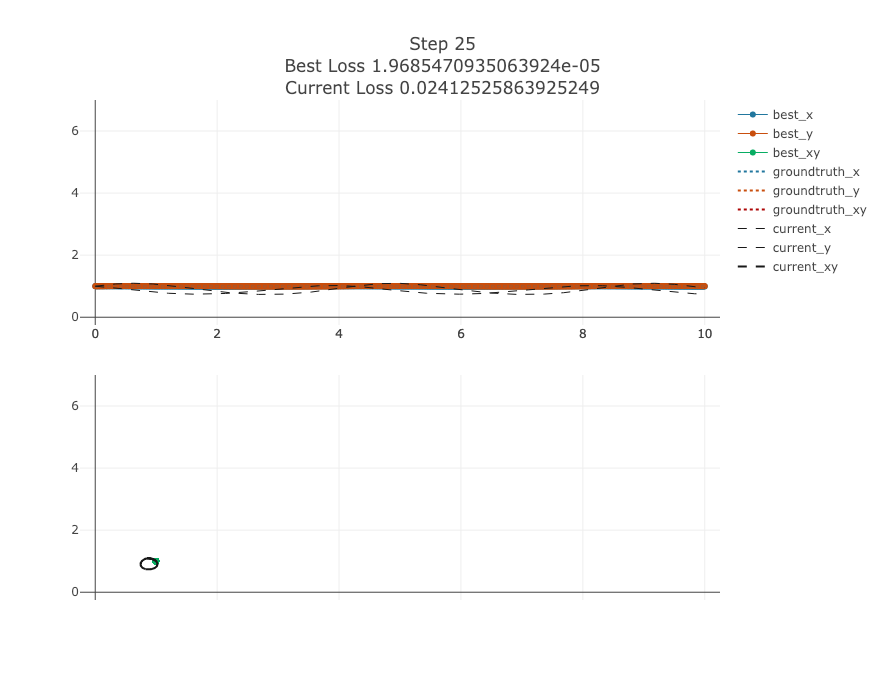

In [11]:
optimize_batch(lotka_volterra, ode_scipy_batch_solver, loss_L2,
         ground_truth_ones, z0, ts,
         args=args, variables=None,
         epochs=25, test_freq=1,
         batch_time=batch_time, data_size=N, batch_size=batch_size,
         y_axis_min=-0.25, y_axis_max=7.0,
         x_axis_min=-0.25, x_axis_max=10.25,
         output_dir="lotka_volterra_optim_scipy")

### TF Runge-Kutta ODE Solver

#### Model

In [12]:
# Tensorflow Variables
# the dimension of our input vector [x, y] => 2
D = 2
N = 200
batch_time=50
batch_size=4
ts = tf.constant(np.linspace(0., 10.0, N))
# the arguments we want to optimize
args = tf.Variable(tf.constant([1.5, 1.0, 3.0, 1.0], shape=(4,), dtype=ts.dtype))

# the initial input value
z0 = tf.Variable(tf.constant([1.0,1.0], shape=(2,), dtype=ts.dtype))

def ode_tf_solver(f, z0, ts, args):
    # f is considered time-invariant for now so who cares about order
    # order is required by TF odeint
    ts = tf.contrib.framework.sort(ts)
    r = ode_tf(f, z0, ts, args)
    r = tf.cast(r, z0.dtype)
    return r

def ode_tf_batch_solver(f, z0s, ts, args):
    if len(z0s.shape) > 1:
        r = ode_tf_solver(f, z0s, ts, args)
        r = tf.transpose(r, [1, 0, 2])
        #ts = tf.contrib.framework.sort(ts)
        #r = ode_tf_batch(f, z0s, ts, args)
        return r
    else:
        return ode_tf_solver(f, z0s, ts, args)

# our ground_truth (all 1.0)
ground_truth_ones = tf.ones(shape=(N, D), dtype=z0.dtype)


#### TF Runge-Kutta ODE Solver Training Video

In [19]:
from IPython.display import HTML

HTML("""
<video width="640" height="480" controls>
  <source src="lotka_volterra_optim_tf/video.mp4" type="video/mp4">
</video>
""")

#### Running Training by yourself

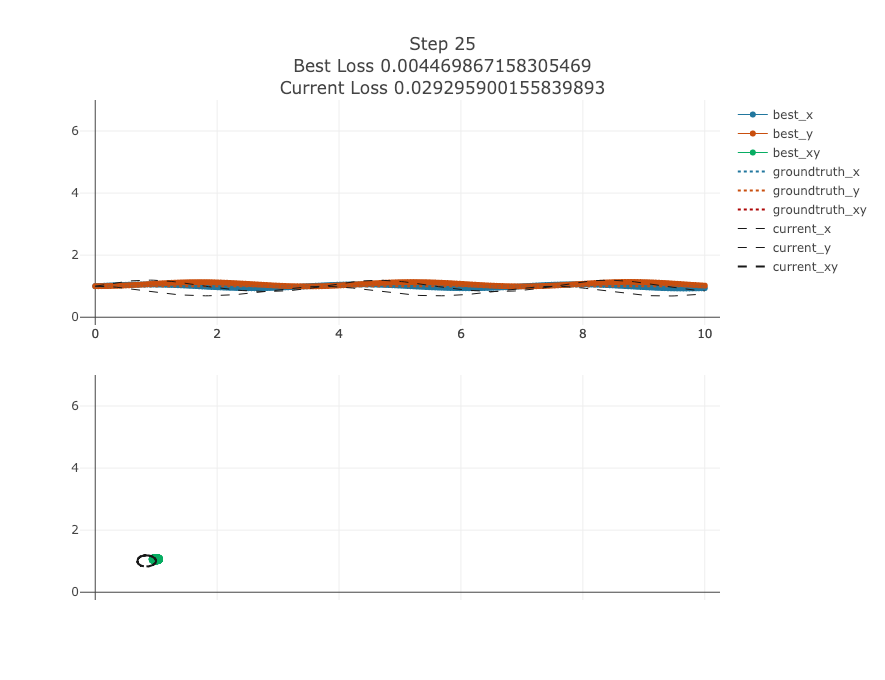

In [18]:
optimize_batch(lotka_volterra, ode_tf_batch_solver, loss_L2,
         ground_truth_ones, z0, ts,
         args=args, variables=None,
         epochs=25, test_freq=1,
         batch_time=batch_time, data_size=N, batch_size=batch_size,
         y_axis_min=-0.25, y_axis_max=7.0,
         x_axis_min=-0.25, x_axis_max=10.25,
         output_dir="lotka_volterra_optim_tf")

## Final Step: learning time-series with Neural ODE

Finally, let's try to learn some time-series function with our neural ODE to check paper assertions are not just imaginary.

We are going to model derivative of our function with a classic one-layer dense neural layer as shown in https://julialang.org/blog/2019/01/fluxdiffeq.

Then we compute our ground-truth using ODE-Solver from true derivative, decide to use L2 loss.

Finally, we launch iterative optimization process using ODE augmented state gradient descent and observe what happens...

I won't launch it with Runge-Kutta as it is much less stable than scipy LSODA... tensors are flowing from GPU to CPU but it's OK for current experimentations...


### Learning a piece of lotka_volterra curve

#### Model

In [13]:
## D = 2
N = 1000
batch_time=10
batch_size=20
ts = tf.constant(np.linspace(0., 10.0, N))
args = tf.Variable(tf.constant([1.5, 1.0, 3.0, 1.0], shape=(4,), dtype=ts.dtype))
z0 = tf.Variable(tf.constant([1.0, 1.0], shape=(2,), dtype=ts.dtype))

model = tf.keras.Sequential([
  tf.keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(1, D)),  # input shape required
  tf.keras.layers.Dense(D)
])

def predict_fn(y, ts, args):
    rank =  tf.rank(y).numpy()
    if rank == 1:
        y = tf.expand_dims(y, 0)
    y = tf.cast(y, tf.float32)
    r = model(y)
    if rank == 1:
        r = tf.squeeze(r)
    r = tf.cast(r, y.dtype)
    return r

ground_truth = ode_scipy(lotka_volterra, z0, ts, args)

#### ODE Scipy Lotka Volterra video of training

In previous implementation without mini-batch training, it was converging very slowly and sometimes diverging.
Now it converges in a few 10s of iterations and oscillates around equilibrium going nearer and nearer as show in Pytorch implementation https://github.com/rtqichen/torchdiffeq. _The green curve in x/y view looks multiple because it does several turns_

Conclusion: Neural ODE is able to learn a tiny time-series (and certainly overfit a lot on it ;))

In [15]:
from IPython.display import HTML

HTML("""
<video width="800" height="600" controls>
  <source src="ode_dense_lotka_volterra/video.mp4" type="video/mp4">
</video>
""")

#### Running the experiment by yourself

> On a 1080TI, it takes around 20mn for 200 epochs

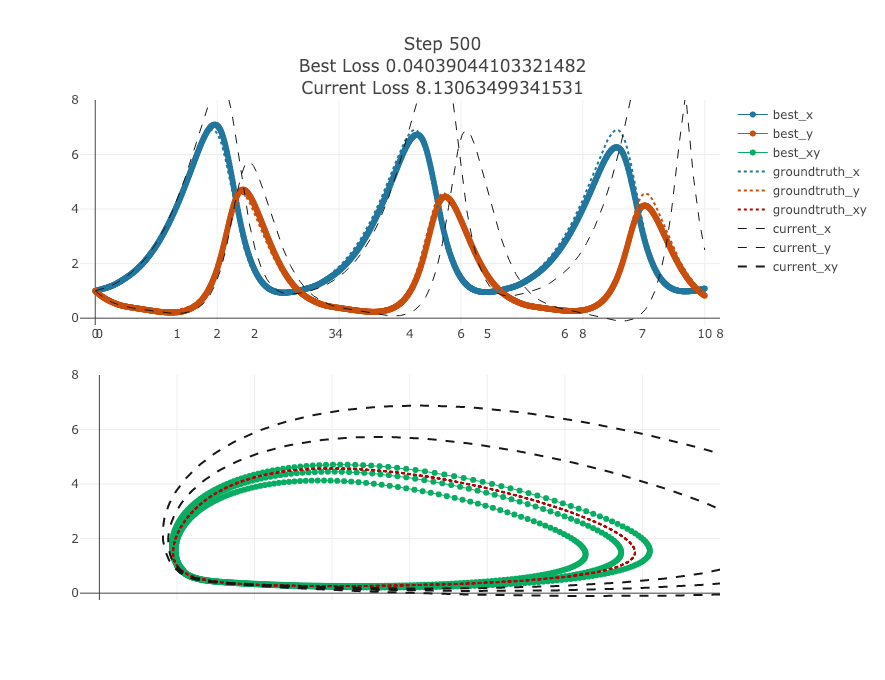

In [14]:
optimize_batch(predict_fn, ode_scipy_batch_solver, loss_L2,
         ground_truth, z0, ts,
         args=None, variables=model.variables,
         epochs=500, test_freq=1, learning_rate=0.01,
         batch_time=batch_time, data_size=N, batch_size=batch_size,
         x_axis_min=-0.25, x_axis_max=10.25,
         y_axis_min=-0.25, y_axis_max=8.0,
         x2_axis_min=-0.25, x2_axis_max=8.0,
         y2_axis_min=-0.25, y2_axis_max=8.0,
         output_dir="ode_dense_lotka_volterra")

#### Result of training

In [ ]:
zs = ode_scipy(predict_fn, z0, ts, args)

xs = zs[:, 0].numpy()
ys = zs[:, 1].numpy()

iplot([go.Scatter(x=ts.numpy(), y=xs, name="x"), go.Scatter(x=ts.numpy(), y=ys, name="y")])

iplot([go.Scatter(x=xs, y=ys)])

### Learning a piece of Damped 2D oscillator curve but not converging

#### Model

In [14]:
from tensorflow.keras import initializers

D = 2
N = 1000
batch_time = 10
batch_size = 20
ts = tf.constant(np.linspace(0., 25.0, N))
z0 = tf.Variable(tf.constant([2.0, 0.0], shape=(2,), dtype=ts.dtype))

args = tf.Variable(tf.constant([
    # −0.1x^3 + 2.0y^3
    [-0.1, 2.0],
    # −2.0x^3 − 0.1y^3
    [-2.0, -0.1]], shape=(2, 2), dtype=ts.dtype))


model2 = tf.keras.Sequential([
  tf.keras.layers.Dense(25, activation=tf.nn.tanh, input_shape=(1, D),
                        kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.1)),
  tf.keras.layers.Dense(D)
])

def predict_fn2(y, ts, args):
    rank =  tf.rank(y).numpy()
    if rank == 1:
        y = tf.expand_dims(y, 0)
    y = tf.cast(y, tf.float32)
    y = tf.math.pow(y, 3)
    r = model2(y)
    if rank == 1:
        r = tf.squeeze(r)
    r = tf.cast(r, y.dtype)
    return r

ground_truth2 = ode_scipy(damped_oscillator_2d, z0, ts, args)

#func = lambda z0, ts, args: tf.tensordot(z0**3, args, axes=1)
#ground_truth2 = ode_tf(func, z0, ts, args)

#### Oscillator Scipy ODE video of training

In previous implementation of optimizer without mini-batch, it wasn't converging very near from curve, not creating enough loops to cover it all and when reaching some points diverging far and restarting the same process.
Now, it creates nice loops and converges quite well, going nearer and nearer from original curve.
I've stopped it after 500 iterations explaining why it's not exactly near the curve when looking in x or y

In [17]:
from IPython.display import HTML

HTML("""
<video width="800" height="600" controls>
  <source src="ode_dense_damped_oscillator_2d/video.mp4" type="video/mp4">
</video>
""")


#### Running the experiment by yourself

> On a 1080TI, it takes around 3h for 1000 epochs

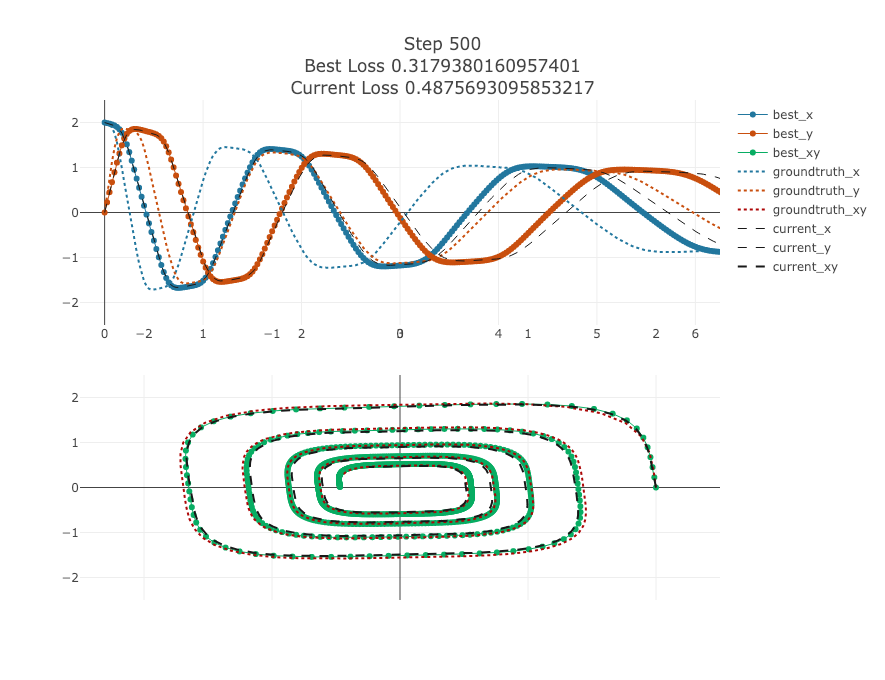

In [15]:

optimize_batch(predict_fn2, ode_scipy_batch_solver,
         loss_L1, ground_truth2, z0, ts,
         learning_rate=0.001,
         batch_time=batch_time, data_size=N, batch_size=batch_size, test_freq=1,
         args=None, variables=model2.variables, epochs=500,
         x_axis_min=-0.25, x_axis_max=6.25,
         y_axis_min=-2.5, y_axis_max=2.5,
         x2_axis_min=-2.5, x2_axis_max=2.5,
         y2_axis_min=-2.5, y2_axis_max=2.5,
         output_dir="ode_dense_damped_oscillator_2d_2", start=0)


## Post Work'em

This is not a post mortem as the study is not finished yet and still on-going.

After reaching this step, I'm truly happy as it works and sounds promising about the paper concepts which are reproducible... I don't pretend it's perfect yet and I can say that trainings are not very fast and tend to differ between runs. Sometimes, it seems to converge at first and then loop without converging further. Yet, it's already quite cool to me :)

But it has been painful... Ok, I'm not yet an expert in TF or Python and I'm still learning both deeper concepts and libraries. But I can say I've been developing for tens of years in complex backend production environment and distributed systems with Native, Java and Scala/FP. From this experience, current state of maturity of TF and AI Python ecosystem, in general, is far from those in terms of robustness, consistency and determinism. Ok, you can have fun with a few pre-built samples but as soon as you go out of the paved road, it becomes hairy and not very deterministic or consistent... Everything takes a lot of time and effort to reach acceptable state... Specially when dealing with custom gradients which tend to crash with no error at all so it's hard to know which part of your graph fails..

I'm (in) eager(-mode) to discover incoming TF 2.x. which should make TF a bit more practical (more like Pytorch) and consistent in terms API... I'm also looking at TF-Swift, not that I like Swift but because a multi-stage compiled auto-diff remains quite appealing to me compared to Pythonic weakness...




## Next steps...

_This notebook is the first one of a few incoming studies I'll publish when I find a few minutes as I'm also implementing Time-series models and Continuous Normalizing Flows as explained in the paper..._

I want to test more networks for derivative or time distribution and see how it can speed trainings...

I want to make a quick Pytorch implementation and compare to TF 1.x.

I want to see how they check full-GPU ODE Solvers in Julia or Pytorch...

I want to play with depth distribution as a learnable parameter...